# T5 - Transmission

Many infectious diseases transmit when people come into contact with one another. In the basic SIR example that we covered in the first two tutorials, we used a 'random' contact network, which creates random pairings of people. Generally speaking, the structure of network that you use depends on what disease you're modeling.

Starsim contains two different approaches to disease transmission.

**Contact network:** Disease transmits on individual person-to-person relationships. These are networks in the sense that each agent (person) can be viewed as a node and each contact is an edge. Networks are undirected in the sense that an edge will allow transmission in both directions, however you can make transmission stronger one way (p1-->p2) than the other (p2-->p1). The framework includes several pre-built contact network algorithms, each of which manages a list of edges that can change on each simulation step. In addition to the 'random' network, the framework include algorithms representing basic sexual networks for modeling sexually transmitted infections (STIs) and a 'maternal' network for modeling mother-to-child transmission.

**Mixing pools:** Simulate well-mixed transmission from one group of agents to another. Each mixing pool simulates directed transmission from a group of source agents to a group of destination agents. Instead of simulating individual edges like in a contact network, mixing pools first compute the total "contagion" that is shed by the source group. This total contagion value is normalized by the number of agents in the source group to arrive at a value that represents a typical infectious source agent. Then, each destination agent is exposed to this typical (average) infectious agent, likely resulting in new infections in the destination group. Multiple mixing pools can be run simultaneously to simulate heterogeneous transmission between various source and destination groups. Mixing pools could be used with age contact matrices like those developed by Prem et al.

Note that contact networks and mixing pools can be used together in a single simulation.

In this tutorial, we'll demonstrate a couple of the built-in contact networks, and give an overview of how you might create your own for your own disease modeling work. We'll also demonstrate how to use mixing pools.

## Overview of Starsim's contact network structure

Starsim's networks are stored in the `networks.py` file. At the top of this file you'll see the `Network` class, which provides the template for all the other networks. At a high level, all you need to know is that network stores various *parameters* that determine how pairs of people form and dissolve, and a collection of all the *edges* that exist at a given point in time. Let's look at a simple example of the `random` network:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import starsim as ss
import numpy as np
import matplotlib.pyplot as plt

# Make random network
random = ss.RandomNet()

Starsim 2.0.1 (2024-10-11) — © 2023-2024 by IDM


The network we just made stores two very important things: the list of contacts (found in `random.edges`) and the parameters (`random.pars`).  

If we just make a network on its own like this, it's not very interesting. Like all components of Starsim, it needs to be initialized within a `sim` before the database of contacts gets populated:

In [2]:
net = ss.RandomNet()
sir = ss.SIR()
sim = ss.Sim(n_agents=100, diseases=sir, networks=net) # Decreasing n_agents so we can plot the network below
sim.init()

Initializing sim with 100 agents


Sim(n=100; 2000—2050; networks=randomnet; diseases=sir)

We can easily take a look at the list of edges between agents. All networks are stored in `sim.networks`, and individual networks can be found at their class name after conversion to lower case. So for this example, `sim.networks.randomnet.edges` has all the information about which agents (referenced by their UID) are paired with which other agents as well as a per-edge transmission multiplier called `beta` and a per-edge duration, `dur`.

In [3]:
sim.networks.randomnet

randomnet("randomnet", p1, p2, beta, dur)
     p1  p2  beta  dur
0     0  95   1.0  0.0
1     0  43   1.0  0.0
2     0  50   1.0  0.0
3     0  35   1.0  0.0
4     0  18   1.0  0.0
..   ..  ..   ...  ...
495  99  50   1.0  0.0
496  99  51   1.0  0.0
497  99  95   1.0  0.0
498  99  82   1.0  0.0
499  99  98   1.0  0.0

[500 rows x 4 columns]

Networks provide some basic functionality, for example to identify contacts. Additionally, the edge list can be quickly converted to a Pandas data frame for further analysis and manipulation.

The following agents were identified as contacts of agent 0: [18 35 37 43 47 50 54 72 95]

Edges involving UID 0 extracted from the edge list data frame:


,p1,p2,beta,dur
0,0,95,1.0,0.0
1,0,43,1.0,0.0
2,0,50,1.0,0.0
3,0,35,1.0,0.0
4,0,18,1.0,0.0
175,35,0,1.0,0.0
186,37,0,1.0,0.0
238,47,0,1.0,0.0
272,54,0,1.0,0.0
363,72,0,1.0,0.0


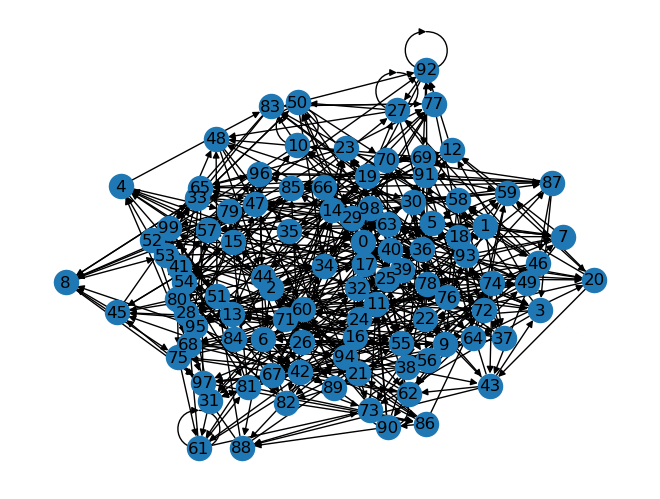

In [4]:
net = sim.networks.randomnet

# Use the "find_contacts" function to find all contacts of agent with uid 0
contacts_of_agent_0 = net.find_contacts([0])
print('The following agents were identified as contacts of agent 0:', contacts_of_agent_0)

# Convert to a pandas DataFrame and manually find all edges involving agent with uid 0
df = net.to_df()
uid0_edges = df.loc[(df['p1']==0) | (df['p2']==0)]
print('\nEdges involving UID 0 extracted from the edge list data frame:')
display(uid0_edges)

import networkx as nx
G = net.to_graph()
nx.draw(G, with_labels=True)


## Sexual networks
Starsim contains a few basic sexual networks, including an `mf` network for modeling heterosexual partnerships and an `msm` network for men having sex with men. Modeling STIs is a straightforward extension of the SIR example we looked at previously. Here's an example modeling syphilis:

In [5]:
# Create the disease
syph = ss.Syphilis(
    beta = {'mf': [0.25, 0.15]},    # See notes below 
)

# Create a heterosexual network
mf = ss.MFNet(
    duration=1/24,  # Using very short relationships so that we get more transmission 
    acts=80,        # Distribution of the number of coital acts/year
)

pars = dict(start=2000, dur=20, dt=1/12)
sim = ss.Sim(pars=pars, diseases=syph, networks=mf)

The main difference here is that we've added the line `syph.pars['beta'] = {'mf': [0.25, 0.15]}`. Because STIs are generally more transmissible from males to females than vice versa, we can specify `beta` as a list, and we can also allow it to vary between networks. For instance, if we also had an MSM network here, we could set 
```
syph.pars.update(beta = {'mf': [0.25, 0.15], 'msm': [0.4, 0.4]})
```
The sexual network itself is structurally similar to the `random` network that we looked at previously, and can be customized by changing the `pars` dictionary that's used to construct it.
 
## Maternal networks
Maternal networks are useful for capturing mother-to-child transmission. If you want to use them, you also need to model pregnancy. As new agents are born via pregnancy, edges are automatically added between mother and prenatal child in the maternal network. Here's an example showing how you would do this for syphilis:

In [6]:
syph = ss.Syphilis(
    beta = {'mf': [0.25, 0.15], 'maternal': [0.99, 0]}
)

# Make demographic modules
pregnancy = ss.Pregnancy(fertility_rate=20)
death = ss.Deaths(death_rate=15)

# Make maternal network
maternal = ss.MaternalNet()

# Make sim
sim = ss.Sim(pars=pars, diseases=syph, networks=[mf, maternal], demographics=[pregnancy, death])

## Making your own contact network
If you want to make your own network, a good place to start is by inheriting from one of the templates in networks.py. For example, if you wanted to make an `mf` network that has more age structure, you could do something like this:

In [7]:
class age_mf(ss.MFNet):
    def add_pairs(self, people, ti=None):
        # Custom code to select pairs based on age
        return 

This network would operate exactly like the existing `mf` network, but you could control how new pairs were added.


# Mixing Pools

Mixing pools are currently implemented as `Interventions` within the Starsim Framework. You will find the `MixingPool` and `MixingPools` classes in `interventions.py`.

To begin, let's compare a simple SIR model configured with transmission using a single Mixing Pool to a similar model using a contact network. Mixing pools are not the same as contact networks, so the results are not expected to be identical.

Elapsed time: 1.29 s


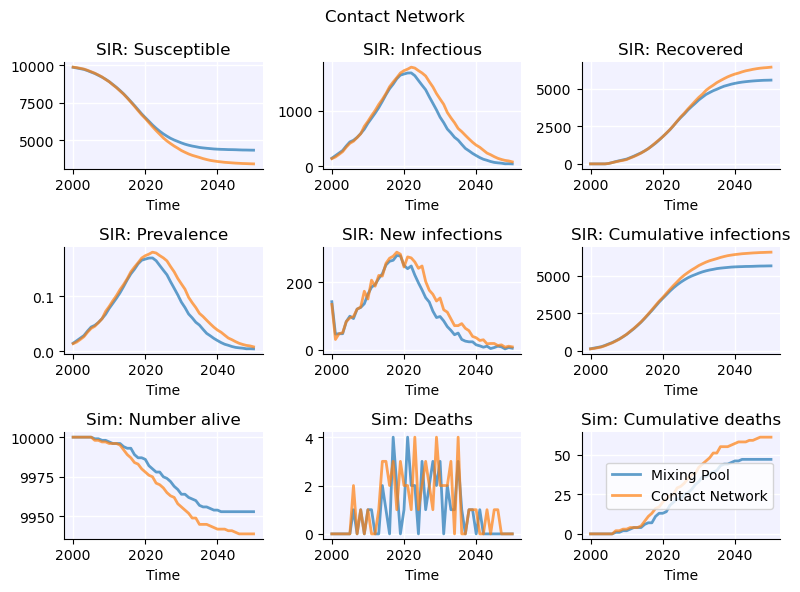

In [125]:
# Transmission using a mixing pool
mp = ss.MixingPool(beta=ss.beta(0.1), contacts=ss.poisson(lam=3)) # A single mixing pool
sir = ss.SIR() # Beta doesn't matter, that's just for networks
sim1 = ss.Sim(diseases=sir, interventions=mp, verbose=0, label='Mixing Pool')

# Transmission using a network
net = ss.RandomNet(n_contacts=ss.poisson(lam=3))
sir = ss.SIR(beta=ss.beta(0.1))
sim2 = ss.Sim(diseases=sir, networks=net, verbose=0, label='Contact Network')

msim = ss.MultiSim([sim1, sim2]).run()
msim.plot();

Each MixingPool has several configuration parameters, including `src` and `dst`. The value of these parameters can either be an array of uids, like `ss.uids([0,1,2])` or a callable function that takes `sim` as an argument and returns an array of uids (or a BoolArr) like `lambda sim: sim.people.age<10`. One helper class we have created is called `AgeGroup`, which takes `low` and `high` ages as parameters. This class has some performance advantages when using multiple pools via `MixingPools` through caching.

While mixing pools do not represent individual agent-to-agent connections, each agent does have an "effective" number of contacts, typically drawn from a Poisson distribution. Individuals retain their number of contacts within each pool for the duration of the simulation. Effective contacts are used on the acquisition sides. On the transmission side, the "average" infection level, called `trans`, against which susceptible agents are challenged is computed as:
```python
trans = np.mean(disease.infectious[self.src_uids] * disease.rel_trans[self.src_uids])
```
And on the acquisition side, each susceptible agent can be thought of as connected to `eff_contacts` average infectious agents, computed as:
```python
acq = self.eff_contacts[self.dst_uids] * disease.susceptible[self.dst_uids] * disease.rel_sus[self.dst_uids]
```
Ultimately, the acquisition probability for each susceptible agent in `dst_uids` is computed as
```python
p = self.pars.beta * trans * acq
```

You can see the `beta` parameter here, which is another pool parameter and should use `ss.beta()` to automatically adjust for time units. Mixing pools do not currently use the `beta` parameters configured in individual disease modules.

Initializing sim with 10000 agents
  Running 2000.0 ( 0/51) (0.00 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.04 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.07 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (0.10 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (0.13 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (0.16 s)  •••••••••••••••••••• 100%



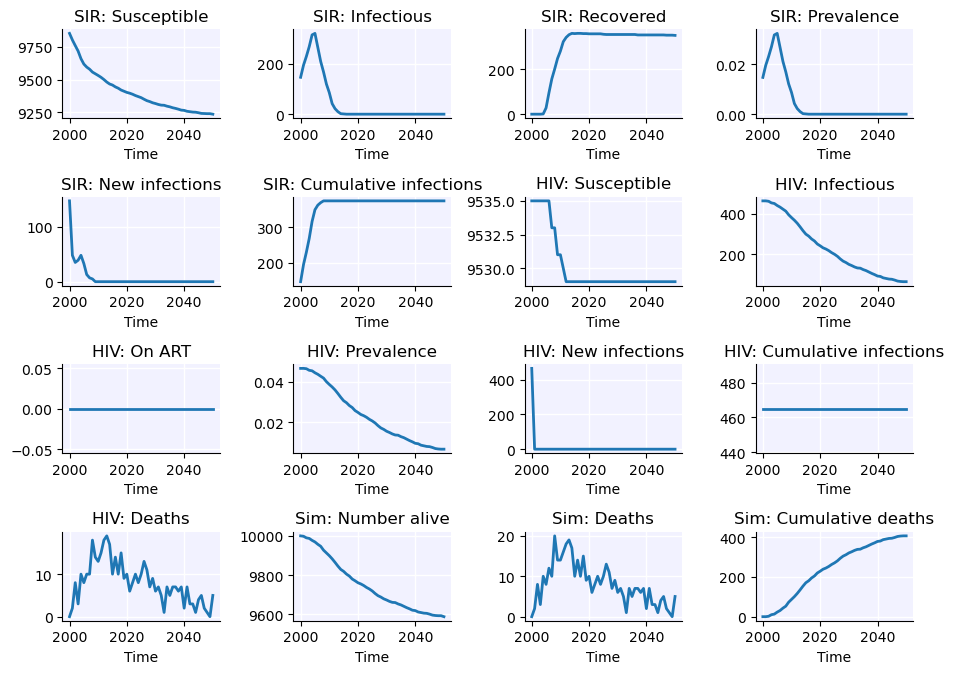

In [121]:
mp = ss.MixingPool(
    diseases = 'sir', # Use this pool only for SIR, not other diseases (HIV in this example)
    src = lambda sim: sim.people.age < 15, # Infection sources will be agents under age 15
    dst = ss.AgeGroup(low=15, high=None), # Here demonstrating the AgeGroup class, identical to lambda sim: sim.people.age >= 15
    contacts = ss.poisson(lam=2), # Contacts will be poisson distributed with a mean of 2
    beta = ss.beta(0.2), # And we set beta to 0.2, automatically adjusting for time units via the ss.beta wrapper
)
sim = ss.Sim(diseases=['sir', 'hiv'], interventions=mp) # Two diseases, only "sir" will have transmission
sim.run()
sim.plot();

`MixingPools` (plural) allows you to configure multiple individual `MixingPool` pools. This first example shows how to do age mixing. Like `MixingPool`, `MixingPools` also takes `src` and `dst`, however each of these parameters must be a dictionary with key specifying the name of each group and value as in the singlular mixing pool proving the uids by a callable function or list of uids.

The first axis (rows) of the contact matrix is the SOURCE group
The second axis (columns) of the contact matrix is the DESTINATION group
^^^ The default age distribution is uniform, so the 75+ group contains many more people than the other age groups, explaining the larger number of new infections.


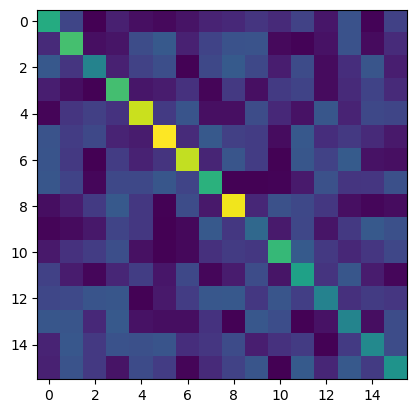

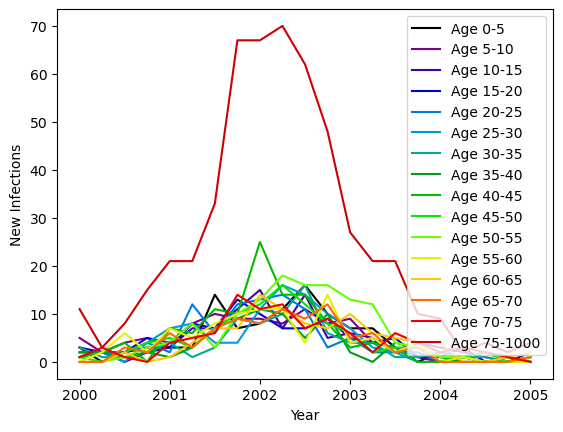

In [126]:
lows = np.arange(0, 80, 5)
#groups = {f'{low}-{high}': ss.AgeGroup(low=low, high=low+5) for low in lows}
groups = ss.ndict([ss.AgeGroup(low=low, high=low+5) for low in lows[:-1]])
groups.append(ss.AgeGroup(low=lows[-1], high=None)) # 80+
#groups[-1].high = None # Make the final group 80+ instead of 80=85
n_groups = len(groups)

# Let's create a random contact matrix. If using contact matrices from Prem et al., put data here.
cm = np.random.random((n_groups, n_groups)) + 3*np.diag(np.random.rand(n_groups))

print('The first axis (rows) of the contact matrix is the SOURCE group')
print('The second axis (columns) of the contact matrix is the DESTINATION group')
plt.imshow(cm)

mps = ss.MixingPools(
    contact_matrix = cm,
    beta = ss.beta(0.2),
    src = groups,
    dst = groups,
)

# Track new infections by age using an Analyzer, you'll learn about these in a subsequent tutorial
class New_Infections_By_Age(ss.Analyzer):
    def __init__(self, bins, **kwargs):
        super().__init__(**kwargs)
        self.bins = bins

    def init_post(self):
        super().init_post()
        self.new_cases = np.zeros((self.npts, len(self.bins)-1))

    def step(self):
        new_inf = self.sim.diseases.sir.ti_infected == self.ti
        if not new_inf.any(): return
        self.new_cases[self.ti, :] = np.histogram(self.sim.people.age[new_inf], bins=self.bins)[0]

    def plot(self):
        fig, ax = plt.subplots()
        ax.set_prop_cycle('color', plt.cm.nipy_spectral(np.linspace(0, 1, len(self.bins))))

        for i, (b1, b2) in enumerate(zip(self.bins[:-1], self.bins[1:])):
            ax.plot(self.sim.timevec, self.new_cases[:,i], label=f'Age {b1}-{b2}')
        ax.legend(); ax.set_xlabel('Year'); ax.set_ylabel('New Infections')

az = New_Infections_By_Age(np.concatenate([lows, [1000]]))

sir = ss.SIR()
sim = ss.Sim(diseases=sir, interventions=mps, analyzers=az, dur=5, dt=1/4, n_agents=2000, verbose=0)
sim.run()
sim.analyzers[0].plot()
print('^^^ The default age distribution is uniform, so the 75+ group contains many more people than the other age groups, explaining the larger number of new infections.')

Mixing pools work well with properties other than age. Here's an example that mixes by socio-economic status (SES).

Infections are seeded into the HIGH group at the beginning of the
simulation, explaining the spike in new cases at that time. HIGH SES can only
infect MID SES, so the MID (orange) wave follows. LOW SES can only become
infected by MID SES in this example, so the blue wave follows. This example
intentionally demonstrates the directional nature of mixing pools and includes
strong mixing within groups and bottlenecks between groups to make the point.


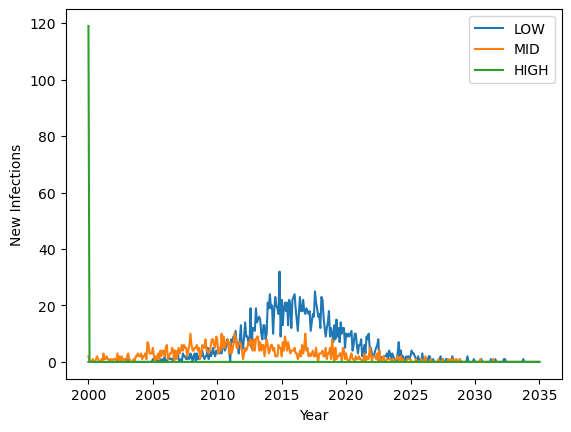

In [130]:
from enum import IntEnum
class SES(IntEnum):
    LOW = 0
    MID = 1
    HIGH = 2

# Create 5,000 people adding 50% LOW, 30% MID, and 20% HIGH SES
ses = ss.FloatArr('ses', default=ss.choice(a=[SES.LOW, SES.MID, SES.HIGH], p=[0.5, 0.3, 0.2]))
ppl = ss.People(n_agents=5_000, extra_states=ses)

# Create the mixing pools, note that the contact matrix need not be symmetric
mps = ss.MixingPools(
    src = {s.name: lambda sim, s=s: ss.uids(sim.people.ses == s) for s in [SES.LOW, SES.MID, SES.HIGH]},
    dst = {s.name: lambda sim, s=s: ss.uids(sim.people.ses == s) for s in [SES.LOW, SES.MID]}, # People in the HIGH group have not route to acquire new infections, for demonstration purposes here

    # src on rows (1st dimension), dst on cols (2nd dimension)
    contact_matrix = np.array([
        [2.50, 0.00], # LOW->LOW,  LOW->MID
        [0.05, 1.75], # MID->LOW,  MID->MID
        [0.00, 0.15], # HIGH->LOW, HIGH->MID
    ]),

    beta = ss.beta(0.2),
)

# Create an analyzer to track results by SES group
class New_Infections_By_SES(ss.Analyzer):
    def init_results(self):
        self.new_cases = np.zeros((self.npts, len(SES)))

    def step(self):
        new_inf = self.sim.diseases.sir.ti_infected == self.ti
        if not new_inf.any():
            return

        for ses in SES:
            self.new_cases[self.ti, ses] = np.count_nonzero(new_inf & (self.sim.people.ses==ses))

az = New_Infections_By_SES()

def seeding(self, sim, uids):
    p = np.zeros(len(uids))
    high_ses = ss.uids(sim.people.ses == SES.HIGH)
    p[high_ses] = 0.1 # Seed infections into 10% of SES HIGH
    return p
sir = ss.SIR(init_prev = ss.bernoulli(p=seeding)) # The probability of being selected as a seed is determined on a per-agent basis by the above 'seeding' function

sim = ss.Sim(people=ppl, diseases=sir, interventions=mps, analyzers=az, dt=1/12, dur=35, verbose=0)
sim.run()


fig, ax = plt.subplots()
new_cases = sim.analyzers[0].new_cases
for ses in [SES.LOW, SES.MID, SES.HIGH]:
    ax.plot(sim.results.timevec, new_cases[:,ses], label=ses.name)
ax.legend(); ax.set_xlabel('Year'); ax.set_ylabel('New Infections');

In the above figure, infections are seeded into the HIGH group at the beginning of the simulation, explaining the spike in new cases at that time. HIGH SES can only infect MID SES, so the MID (orange) wave follows. LOW SES can only become infected by MID SES in this example, so the blue wave follows. This example intentionally demonstrates the directional nature of mixing pools and includes strong mixing within groups and bottlenecks between groups to make the point.